<center>
    <img src="https://gitlab.com/ibm/skills-network/courses/placeholder101/-/raw/master/labs/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1>Model Evaluation and Refinement with Tidymodels</h1>

Estimated Time Needed: **45 min**


### Welcome!

We have built models and made predictions of flight delays. Now we will determine how accurate these predictions are.

You will learn techniques for evaluating the performance of your models. This inludes how to split your dataset into training and testing sets, build and train linear regression models with a training set, compute metrics to assess the performance of models, and tune hyperparameters. Moreover, you’ll also learn a technique for handling cases with small datasets.


## Table of Contents

*   [1. Model Evaluation](#evaluation)
*   [2. Over-fitting, Under-fitting and Model Selection](#selection)
*   [3. Regularization: Ridge regression, Lasso regression and Elastic Net](#ridge)
*   [4. Grid Search](#grid)


## Setup

<p>
Before you can start diving into model evaluation, you first need to load the libraries and data.


<h4>Load Libraries</h4> 

In the previous labs, you used base R's `lm()` to create linear regression models. In this lab, we will introduce another way to create models with **Tidymodels**.

Tidymodels is a collection of packages that use tidyverse principles to easily do the entire modeling process from preprocessing initial data, to creating a model, to tunning hyperparameters.

Below, install "tidymodels", additionally "rlang" should be updated in order to properly run "tidymodels".

**Note**: The installation of "rlang" and "tidymodels" may take a while in the Skill Network Labs. Please give it some time or rerun the cell if you are waiting for more than 10 minutes.


In [1]:
update.packages("rlang")

In [2]:
# Install tidymodels if you haven't done so
install.packages("rlang")
install.packages("tidymodels")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


After installing the packages, load them. As with the other labs, we will be using "tidyverse" as well.


In [3]:
# Library for modeling
library(tidymodels)

# Load tidyverse
library(tidyverse)

── Attaching packages ────────────────────────────────────── tidymodels 0.1.4 ──
✔ broom        0.7.9      ✔ recipes      0.1.17
✔ dials        0.0.10     ✔ rsample      0.1.0 
✔ dplyr        1.0.7      ✔ tibble       3.1.5 
✔ ggplot2      3.3.5      ✔ tidyr        1.1.4 
✔ infer        1.0.0      ✔ tune         0.1.6 
✔ modeldata    0.1.1      ✔ workflows    0.2.4 
✔ parsnip      0.1.7      ✔ workflowsets 0.1.0 
✔ purrr        0.3.4      ✔ yardstick    0.0.8 
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ stringr 1.4.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::co

#### Load Data


As a reminder, you can find the "Airline Data Set" from the following link: <a href="https://dax-cdn.cdn.appdomain.cloud/dax-airline/1.0.1/lax_to_jfk.tar.gz?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDA0151ENSkillsNetwork21582452-2021-01-01"><https://dax-cdn.cdn.appdomain.cloud/dax-airline/1.0.1/lax_to_jfk.tar.gz></a>.
We will be using the LAX to JFK sample data set throughout this course.

</p>


In [4]:
# url where the data is located
url <- "https://dax-cdn.cdn.appdomain.cloud/dax-airline/1.0.1/lax_to_jfk.tar.gz"

# download the file
download.file(url, destfile = "lax_to_jfk.tar.gz")

# untar the file so we can get the csv only
# if you run this on your local machine, then can remove tar = "internal" 
untar("lax_to_jfk.tar.gz", tar = "internal")

# read_csv only 
sub_airline <- read_csv("lax_to_jfk/lax_to_jfk.csv",
                     col_types = cols('DivDistance' = col_number(), 
                                      'DivArrDelay' = col_number()))

Warning message in untar2(tarfile, files, list, exdir, restore_times):
“using pax extended headers”

<a class="anchor" id="evaluation"></a>

## 1. Model Evaluation

### 1.1 Training and Testing Data

An important step in testing your model is to split your data into training and testing data. The training data will be used to train (fit) models, while the testing data will not be touched until we are evaluating the model.

Using other packages or programming languages may require to separate out the reponse variable (`ArrDelayMinutes` in this case) into another dataframe, but here that is not necessary. The response and predictor variables can all stay in one dataframe.

Before splitting the data we:

*   Use the principles learned in module 2 and use `replace_na()` to replace the NAs in the variables we are using to predict. Here, we choose to replace the values with 0 because having NA in these variables mean that there was no delay.
*   Use `select()` to only include the variables we will use to create a final model.


In [5]:
flight_delays <- sub_airline %>% 
    replace_na(list(CarrierDelay = 0,
                    WeatherDelay = 0,
                    NASDelay = 0,
                    SecurityDelay = 0,
                    LateAircraftDelay = 0)) %>%
    select(c(ArrDelayMinutes, DepDelayMinutes, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay, DayOfWeek, Month))

Now, with the prepared dataset `flight_delays`, you can split the data. A random seed is set so that the way the data is split will be the same every time this code is run, this helps create reproducible results.


In [6]:
set.seed(1234)
flight_split <- initial_split(flight_delays)
train_data <- training(flight_split)
test_data <- testing(flight_split)

In `initial_split()`, you can also set the `prop` parameter to set the proportion of the data to use for training. If it is unspecified like here in the example, then by default it is set to 0.75. This means that the proportion of data that is split into the training data is 75% (so the testing data is 25%).


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #1):</h1>

<b>Use the function "initial_split" to split up the data set such that 80% of the data samples will be utilized for training. The output of the function should be the following:  "flight_split2", "train_data2" , "test_data2".</b>

</div>


In [7]:
# Write your code below and press Shift+Enter to execute 
flight_split2 <- initial_split(flight_delays, prop = 4/5)  # prop = 0.8 works as well
train_data2 <- training(flight_split2)
test_data2 <- testing(flight_split2)

<details>
    <summary>Click here for the solution.</summary>

```r
flight_split2 <- initial_split(flight_delays, prop = 4/5)  # prop = 0.8 works as well
train_data2 <- training(flight_split2)
test_data2 <- testing(flight_split2)
```

</details>


### 1.2 Training a Model

After splitting the dataset, the next step is to create a Linear Regression object by using `linear_reg()` to specify linear regression and `set_engine()` to specify which package is used to create the model.


In [8]:
# Pick linear regression
lm_spec <- linear_reg() %>%
  # Set engine
  set_engine(engine = "lm")

# Print the linear function
lm_spec

Linear Regression Model Specification (regression)

Computational engine: lm 


In this example, we will use Arrival Delay Minutes ("ArrDelayMinutes") as the response variable and Departure Delay Minutes ("DepDelayMinutes") as the predictor variable to fit (train) a model. We will use `train_data` because we are training the model. The `test_data` will be used later.

Use `fit()` to fit the model we just specified in `lm_spec`. The output is the fitted (trained) model.


In [9]:
train_fit <- lm_spec %>% 
    fit(ArrDelayMinutes ~ DepDelayMinutes, data = train_data)

train_fit 

parsnip model object

Fit time:  5ms 

Call:
stats::lm(formula = ArrDelayMinutes ~ DepDelayMinutes, data = data)

Coefficients:
    (Intercept)  DepDelayMinutes  
         2.6832           0.9309  


To look at some of the predictions of the fitted model, use `predict()`, which will output one column with predictions (`.pred`). Here, since `new_data = train_data`, you are looking at how well the model is predicting the original training data.


In [10]:
train_results <- train_fit %>%
  # Make the predictions and save the predicted values
  predict(new_data = train_data) %>%
  # Create a new column to save the true values
  mutate(truth = train_data$ArrDelayMinutes)

head(train_results)

.pred,truth
<dbl>,<dbl>
2.683167,4
120.904574,96
10.130185,18
4.544921,2
2.683167,0
2.683167,0


Additionally, you can use the same fitted model to predict on test data and save to a dataset called `test_results`. There are two columns in the dataset, including both predicted values and true values.

Now it is time to evaluate the models to estimate how well the models perform on new data, the test data. This example uses the same model in `train_fit` to make the predictions. Again, from `predict()`, the output is stored in a data frame with only one column, called `.pred`. You can then add a new column to this data frame using the `mutate()` function. This new column is named `truth` and contains values of "ArrDelayMinutes" from the `test_data`. In the end, you will have a dataframe with the predictions and the true values.


In [11]:
test_results <- train_fit %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data) %>%
  # Create a new column to save the true values
  mutate(truth = test_data$ArrDelayMinutes)

head(test_results)

.pred,truth
<dbl>,<dbl>
2.683167,0
16.646325,7
4.544921,5
2.683167,21
2.683167,0
370.379670,682


### 1.3 Evaluating the Model

Next, let's evaluate the model. Using metrics learned in previous lessons like RMSE or R$^2$ are good ways to evaluate *regression* models.

In previous lessons you learned how to claculate RMSE with combinations of functions like `mean()` and `sqrt()`, which is a good exercise. However in practice, this may not be ideal. So more conveniently with "tidymodels", there are already functions like `rmse()` as well as many other metric functions (see [https://yardstick.tidymodels.org/reference/index.html](https://yardstick.tidymodels.org/reference/index.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDA0151ENSkillsNetwork21582452-2021-01-01)).


In [12]:
rmse(train_results, truth = truth,
     estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,13.23765


In [13]:
rmse(test_results, truth = truth,
     estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,16.69547


Using `rsq()`, let's lalculate the R-squared on the training and test data:


In [14]:
rsq(train_results, truth = truth,
    estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.8712265


In [15]:
rsq(test_results, truth = truth,
    estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7900998


You can also make a plot to visualize how well you predicted the Arrival Delay Minutes.

This example plots the actual values (the true values of ArrDelayMinutes) versus the model predictions for both the testing and training datasets. It also plots the line y = x through the origin. This line is a visual representation of the perfect model where all predicted values are equal to the true values in the test set. The farther the points are from this line, the worse the model fit.

Let's break down the code below:

1.  `mutate` - add column called `train` to test_results and set the values all to "testing"
2.  `bind_rows` - do the same to the train_results and bind these rows the test_results
3.  `ggplot` - plot the truth vs prediction values
4.  `geom_abline` - add the y=x line
5.  `geom_point` - add the truth vs prediction points to the plot
6.  `facet_wrap` - since `train` contains two values "testing" and "training", this splits the data into two graphs
7.  `labs` - add labels


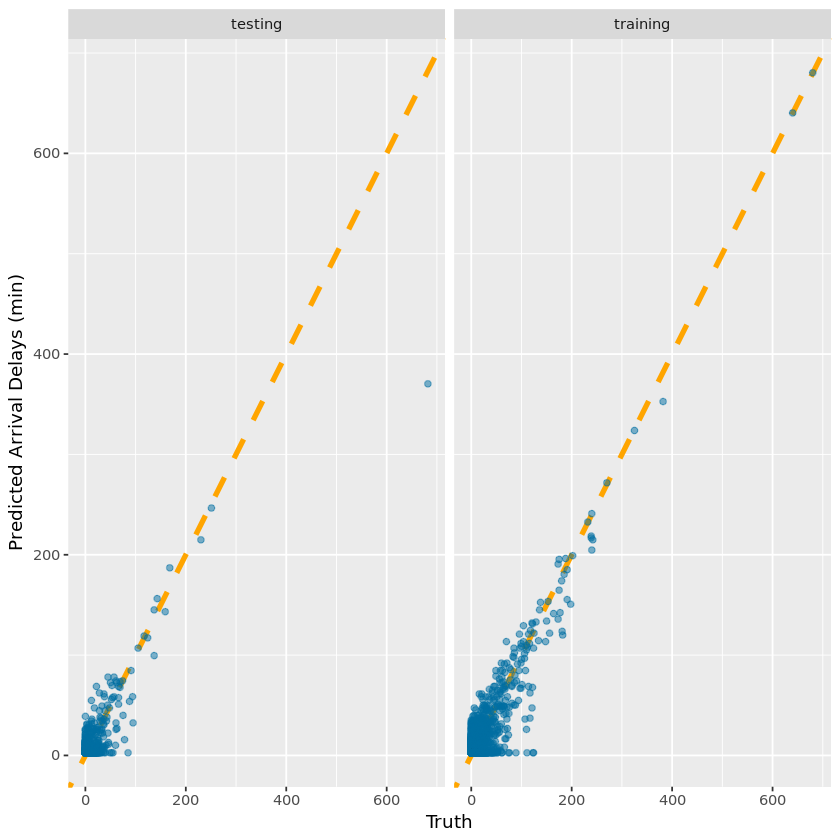

In [16]:
test_results %>%
  mutate(train = "testing") %>%
  bind_rows(train_results %>% mutate(train = "training")) %>%
  ggplot(aes(truth, .pred)) +
  geom_abline(lty = 2, color = "orange", 
              size = 1.5) +
  geom_point(color = '#006EA1', 
             alpha = 0.5) +
  facet_wrap(~train) +
  labs(x = "Truth", 
       y = "Predicted Arrival Delays (min)")

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #2): </h1>
<p> 
Using "ArrDelayMinutes" as the response variable and "DepDelayMinutes" as the predictor variable, find the R^2  on the test data using 80% of the data for training data.
</p>
<p>Hint: use train_data2 from question 1. </p>
</div>


In [17]:
# Write your code below and press Shift+Enter to execute 
train_fit2 <- lm_spec %>% 
    fit(ArrDelayMinutes ~ DepDelayMinutes, 
    data = train_data2)
test_results2 <- train_fit2 %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data2) %>%
  # Create a new column to save the true values
  mutate(truth = test_data2$ArrDelayMinutes)
rsq(test_results2, truth = truth,
    estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7814697


<details>
    <summary>Click here for the solution.</summary>

```r
train_fit2 <- lm_spec %>% 
    fit(ArrDelayMinutes ~ DepDelayMinutes, 
    data = train_data2)
test_results2 <- train_fit2 %>%
  # Make the predictions and save the predicted values
  predict(new_data = test_data2) %>%
  # Create a new column to save the true values
  mutate(truth = test_data2$ArrDelayMinutes)
rsq(test_results2, truth = truth,
    estimate = .pred)
```

</details>


Sometimes you may not have a large enough testing data; as a result, you may want to perform cross validation. Let's  go over several methods that you can use for  cross validation.


### 1.4 Cross validation


One of the most common “out-of-sample” evaluation techniques is **cross validation**.

Cross validation is an effective use of data because each observation is used for both training and testing. In cross validation,

1.  First, the dataset is split into k-equal groups; each group is referred to as a fold.
2.  k - 1 of the folds are used to train a model, and the remaining fold is used to test with an evaluation metric.
3.  This is **repeated** until each of the k groups is used as the test set.
4.  After all folds are used, there are k evaluation metric results. They are **averaged** to get an estimate of out-of-sample error

For example, in 4-fold cross validation you would use three folds for training and then use one fold for testing. The same model would be trained and then tested 4 times using an evaluation metric. The evaluation metric that you use depends on the model, we will use RMSE and R-squared in our code example.

#### Why is it worth the effort to perform cross validation?

Using cross validation means that a model is trained and evaluated many (k) times, however it is still worth the computational cost because it is used to test the generalizability of the model. Generalizability is a measure of how useful the results of a study are for a broader group of people and situations. As you train a model on the training set, it tends to overfit most of the time. To avoid this situation, you can use regularization techniques. Cross validation provides a check on how the model is performing on a test data (new unseen data), and since you have limited training instances, you need to be careful while reducing the amount of training samples and reserving it for testing purposes.

Moreover, cross validation still works well with a **small amount of data**. For example, assume that you only have 100 samples. If you do a train test with an 80 to 20 percent split, then you only have 20 samples in the test set, which is too small to generalize reliable results. With cross validation, you can have as many as k-folds, so you can build k different models. In this case, you can make predictions on all your data and then average out the model performance.

#### Code Example

To perform cross validation, you can use `vfold_cv()`. Setting `v = 10` means that it will use 10 folds. The function `fit_resamples()` will keep refitting the model specified on the samples specified by the cross validation object.


In [18]:
set.seed(1234)
cv_folds <- vfold_cv(train_data, v = 10)
results <- fit_resamples(lm_spec, 
                         ArrDelayMinutes ~ DepDelayMinutes,
                         resamples = cv_folds)

We can calculate the **average** RMSE and R-squared of our estimate:


In [19]:
results %>% collect_metrics()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>
rmse,standard,13.1099177,10,0.68399411,Preprocessor1_Model1
rsq,standard,0.8446594,10,0.02350588,Preprocessor1_Model1


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #3): </h1>
<b> 
Calculate the average RMSE and R-squared using three folds utilizing DepDelayMinutes as a feature : 
</b>
</div>


In [20]:
# Write your code below and press Shift+Enter to execute 
cv_folds_3 <- vfold_cv(train_data, v = 3)
results <- fit_resamples(
    lm_spec, 
    ArrDelayMinutes ~ DepDelayMinutes, 
    resamples = cv_folds_3)
results %>% collect_metrics()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>
rmse,standard,13.2534155,3,0.15688997,Preprocessor1_Model1
rsq,standard,0.8697566,3,0.01018454,Preprocessor1_Model1


<details>
    <summary>Click here for the solution.</summary>

```r
cv_folds_3 <- vfold_cv(train_data, v = 3)
results <- fit_resamples(
    lm_spec, 
    ArrDelayMinutes ~ DepDelayMinutes, 
    resamples = cv_folds_3)
results %>% collect_metrics()
```

</details>


<a class="anchor" id="selection"></a>

## 2. Overfitting, Underfitting and Model Selection

It turns out that the test data sometimes referred to as the out of sample data is a much better measure of how well your model performs in the real world. One reason is **underfitting**. A model that is underfit will have high training and high testing error.

#### How to prevent underfitting?

*   Increase the model complexity
*   Add more features to the training data
*   Try different models

Let's go over an example of underfitting using a simple dataset included with R called "cars". We will predict the distance (`dist`) it takes for cars to stop using the car's speed (`speed`).

In this first example model, the model is defined a line set to the mean of the car's stopping distance. Based on the plot, this model is underfitting because of the speeds less than 10 and greater than 20 are very far from the prediction line.


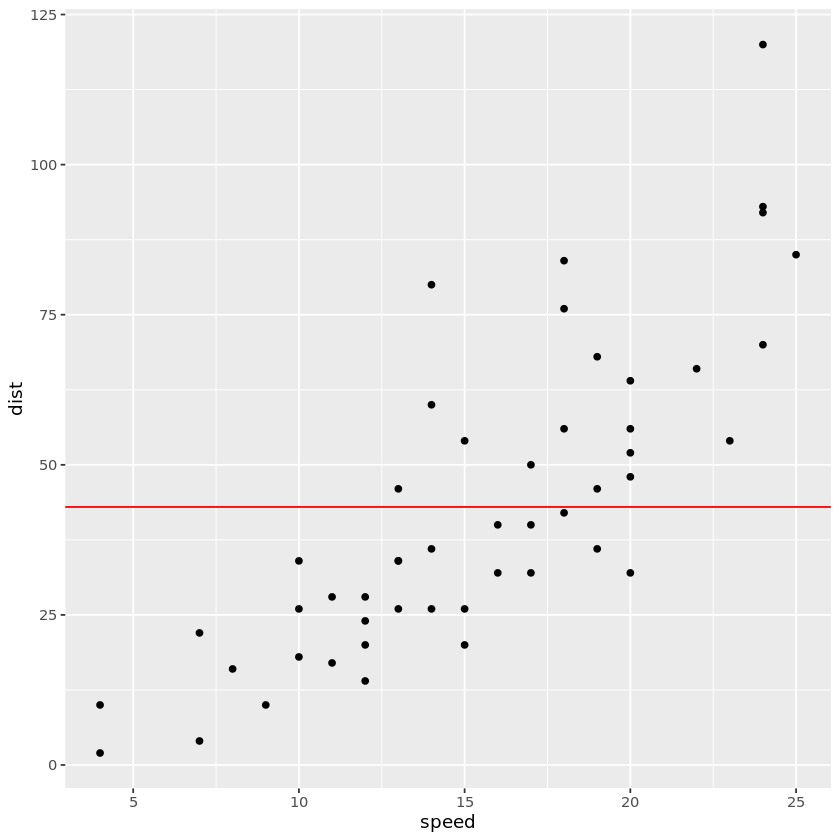

In [21]:
ggplot(cars, aes(x = speed, y = dist)) + 
    geom_point() + 
    geom_hline(yintercept = mean(cars$dist), 
               col = "red") 

Another reason that using the test data to measure the performance of the model is because of **overfitting**. These differences are more apparent in Multiple Linear Regression and Polynomial Regression so we will explore overfitting in that context.

#### How to prevent overfitting?

*   Reduce model complexity
*   Training with more data
*   Cross-validation
*   Regularization

Let's take a look at an example. We use 8th degree polynomial here with `poly(x, 8)` to fit the "car" dataset.


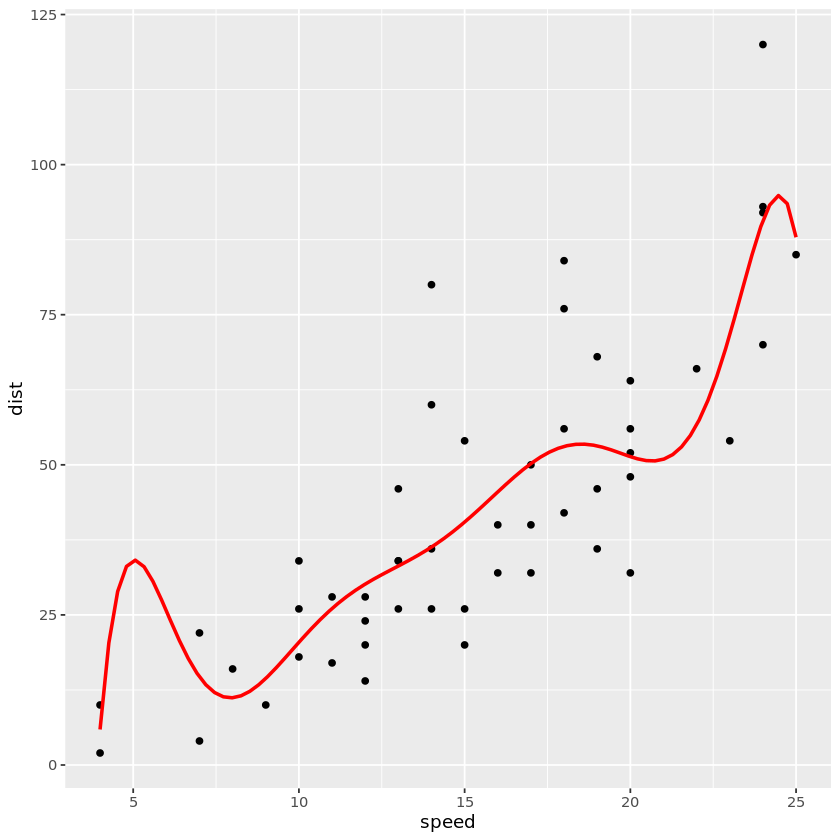

In [22]:
ggplot(cars, aes(x = speed, y = dist)) + 
    geom_point() + 
    geom_smooth(method = "lm", 
                formula = y ~ poly(x, 8), 
                col = "red", se = FALSE) 

The model is fitting to the points in the top right. If this model received new speeds, it may not be able to predict accurate distances.


Going back to the example with the "cars" dataset, you can reduce the complexity of the model. In the previous overfitting example, a polynomial model of 8 degrees was used. Instead, you can use a polynomial of degree 1 or a simple linear regression model. In R, you can set the formula to y over x. In this example, we demonstrated how you can prevent overfitting and underfitting models by changing the model complexity.


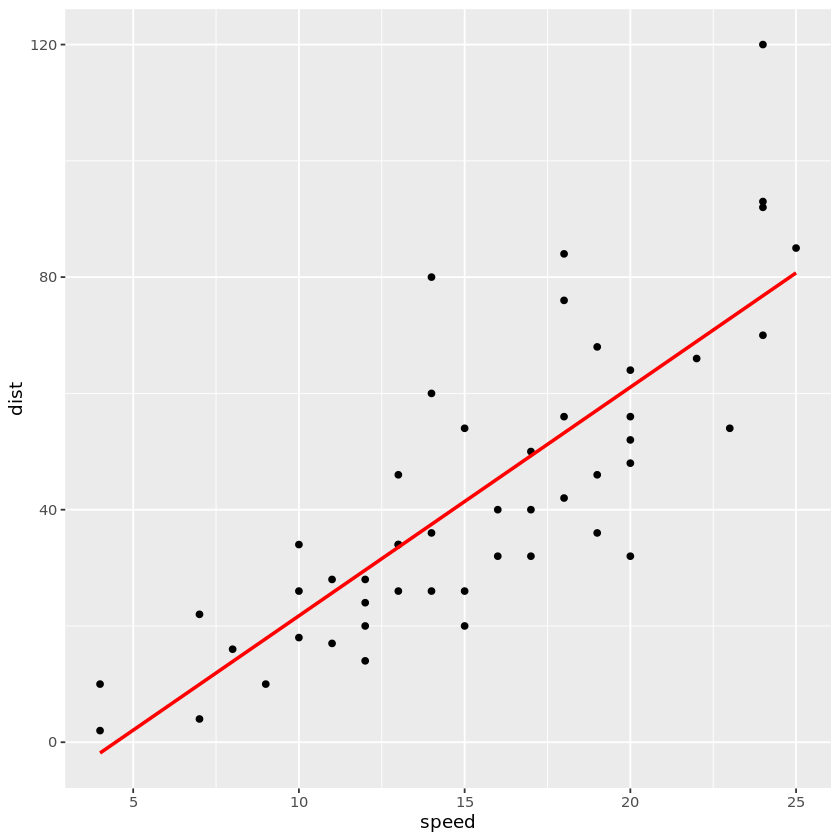

In [23]:
ggplot(cars, aes(x = speed, y = dist)) + 
    geom_point() + 
    geom_smooth(method = "lm", 
                formula = y ~ x, 
                col = "red", 
                se = FALSE) 

<a class="anchor" id="ridge"></a>

## 3. Regularization

Regularization is a way to handle the problem of overfitting. It is a technique you can use to reduce the complexity of the model by adding a penalty on the different parameters of the model. After it is applied, the model will be less likely to fit the noise of the training data and will improve the generalization abilities of the model. So, regularization is a way of *avoiding overfitting* by restricting the magnitude of model coefficients.

There are a few methods of regularizing linear models including

*   Ridge (L2) regularization
*   Lasso (L1) regularization
*   Elastic net (mix of L1 and L2) regularization


### Ridge (L2) regularization

First, create a `recipe()` that includes the model formula. You could preprocess the data more in this step, but the data here is already preprocessed. The dot `.` in the formula is a special character that tells R to use all the variables in train_data.


In [24]:
flight_recipe <-
  recipe(ArrDelayMinutes ~ ., data = train_data)

Next, use the `linear_reg()` function from the tidymodels library to specify the model.

“penalty” is the value of lambda. ”mixture” is the proportion of L1 penalty. For ridge regression, specify **`mixture = 0`**. This means there is no L1 penalty and only the L2 penalty is used. For lasso regression, you would use **`mixture = 1`**.


In [25]:
ridge_spec <- linear_reg(penalty = 0.1, mixture = 0) %>%
  set_engine("glmnet")

Next, create a workflow object so you can more conveniently combine pre-processing, modeling, and post-processing requests.


In [26]:
ridge_wf <- workflow() %>%
  add_recipe(flight_recipe)

Finally, add the ridge model and fit the model.


In [27]:
ridge_fit <- ridge_wf %>%
  add_model(ridge_spec) %>%
  fit(data = train_data)

To view the result of the fitted ridge regression model, use the `pull_workflow_fit()` function.


In [28]:
ridge_fit %>%
  pull_workflow_fit() %>%
  tidy()

Warning message:
“`pull_workflow_fit()` was deprecated in workflows 0.2.3.
Please use `extract_fit_parsnip()` instead.”Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-18



term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),2.74354584,0.1
DepDelayMinutes,0.62721460,0.1
CarrierDelay,0.29353616,0.1
WeatherDelay,0.31756011,0.1
NASDelay,0.55546064,0.1
SecurityDelay,0.05339743,0.1
LateAircraftDelay,0.28670982,0.1
DayOfWeek,0.20576951,0.1
Month,-0.07699068,0.1


There are two results columns. The estimate column contains the estimates of the coefficients learned by the model. Penalty contains the value of lambda, which in this example is 0.1.


### Lasso (L1) regularization

Similarly, here is the code for lasso regression.


### Elastic Net (L1 and L2) Regularization

Moreover, here is the code for elastic net regularization. Like mentioned before, `mixture` is the proportion of L1 penalty used. Since elastic net uses a combination of L1 and L2 regularization, then when `mixture` is set to a value between 0 and 1 (not including 0 and 1) then it is considered elastic net regularization. In this example, it uses less L1 penalty than L2.


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4): </h1>

Perform elastic net regression with "mixture = 0.5" and "penalty = 0.2" using all features (variables) in the training data, and then output the result of the fitted regression model.

</div>


In [29]:
# Write your code below and press Shift+Enter to execute 
flight_recipe <-
  recipe(ArrDelayMinutes ~ ., data = train_data)

el_spec <- linear_reg(penalty = 0.5, mixture = 0.2) %>%
  set_engine("glmnet")

el_wf <- workflow() %>%
  add_recipe(flight_recipe)

el_fit <- el_wf %>%
  add_model(el_spec) %>%
  fit(data = train_data)

el_fit %>%
  pull_workflow_fit() %>%
  tidy()

Warning message:
“`pull_workflow_fit()` was deprecated in workflows 0.2.3.
Please use `extract_fit_parsnip()` instead.”

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),2.13517394,0.5
DepDelayMinutes,0.74911899,0.5
CarrierDelay,0.18665057,0.5
WeatherDelay,0.18631030,0.5
NASDelay,0.53169263,0.5
SecurityDelay,-0.03089712,0.5
LateAircraftDelay,0.17431248,0.5
DayOfWeek,0.09713989,0.5
Month,-0.04113380,0.5


<details>
    <summary>Click here for the solution.</summary>

```r
flight_recipe <-
  recipe(ArrDelayMinutes ~ ., data = train_data)

el_spec <- linear_reg(penalty = 0.5, mixture = 0.2) %>%
  set_engine("glmnet")

el_wf <- workflow() %>%
  add_recipe(flight_recipe)

el_fit <- el_wf %>%
  add_model(el_spec) %>%
  fit(data = train_data)

el_fit %>%
  pull_workflow_fit() %>%
  tidy()
```

</details>


### Comparing Regularization Types

Now that you know more about regularization, it is also good to understand when you would use a techinque over the other.

*   **Lasso (L1)**:
    *   Pros: Lasso is primarily used for variable selection, that is, reducing the number of variables/features used in a model by shrinking the coefficients to zero. You would use this if you have many variables and think just a select few would will be useful in a final model.
    *   Cons: The downside of Lasso is that its variable selection is unstable, as in, for correlated variables it will arbitrarily select one. Additionally, if the number of data point (n) is less than the number of features (p), then Lasso can select at most n of the features.

*   **Ridge (L2)**:
    *   Pros: If you don’t want to reduce the number of variables, you can use this. Ridge also works well when there is multicollinearity in the features because it reduces the variance while increasing bias.
    *   Cons: Will not reduce the number of variables if that is your goal. Also, the bias in the model may be high.

*   **Elastic net (L1/L2)**:
    *   Pros: Elastic net combines the benefits of Lasso and Ridge. It solves some of the issues that Lasso has when doing variable selection because it works well when the variables are highly correlated and it can work when the number of variables is greater than the number of samples.
    *   Cons: May be computationally more expensive than Lasso or Ridge because it computes both L1 and L2 penalties.


<a class="anchor" id="grid"></a>

## Part 4: Grid Search

The goal of grid search is to find the values of the hyperparameters that results in the best model. This is known as tuning hyperparameters. Hyperparameters are parameters that are not derived from training the model. For example: 𝜆 (or lambda) in ridge/lasso is a hyperparameter.

Grid search takes a list of values for each hyperparameter it is tuning and iterates through each combination. It then uses every combination of parameters to produce a model. For each model, a metric like RMSE is calculated. You then determine the best value of the hyperparameters by choosing the model with the best RMSE. In R, you can use functions in tidymodels to run grid search.


First, define the lasso model. In this example, we will be tuning a lasso model so `mixture = 1`. We will tune lambda, which is `penalty` in the function.


In [30]:
tune_spec <- linear_reg(penalty = tune(), mixture = 1) %>% 
  set_engine("glmnet")

lasso_wf <- workflow() %>%
  add_recipe(flight_recipe)

Next, define cross validation to resample the data:


In [31]:
flight_cvfolds <- vfold_cv(train_data)

Now, you can set up the grid using `grid_regular()`. The `levels` are how many values to use and in `penalty()` you can specify the range of values to use. By default, the range values are inverse log transformed. This means that $-3$ is really $10^{-3}$ and $0.3$ is really $10^{0.3}$.


In [32]:
lambda_grid <- grid_regular(levels = 50,
  penalty(range = c(-3, 0.3)))

To tune the grid, use `tune_grid()` and include the lambda grid just specified.


In [33]:
lasso_grid <- tune_grid(
    lasso_wf %>% add_model(tune_spec), 
    resamples = flight_cvfolds, 
    grid = lambda_grid)

Finally, to view best results:


In [34]:
show_best(lasso_grid, metric = "rmse")

penalty,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>
0.2275846,rmse,standard,11.15831,10,0.5379352,Preprocessor1_Model36
0.1948929,rmse,standard,11.15894,10,0.5391945,Preprocessor1_Model35
0.1668972,rmse,standard,11.15977,10,0.5399787,Preprocessor1_Model34
0.2657601,rmse,standard,11.16044,10,0.5359803,Preprocessor1_Model37
0.1429230,rmse,standard,11.16074,10,0.5407935,Preprocessor1_Model33


From the table and using RMSE as the metric, using lambda (penalty) equal to 1.46 gives the best result.

Additionally, to visualize the RMSE results:


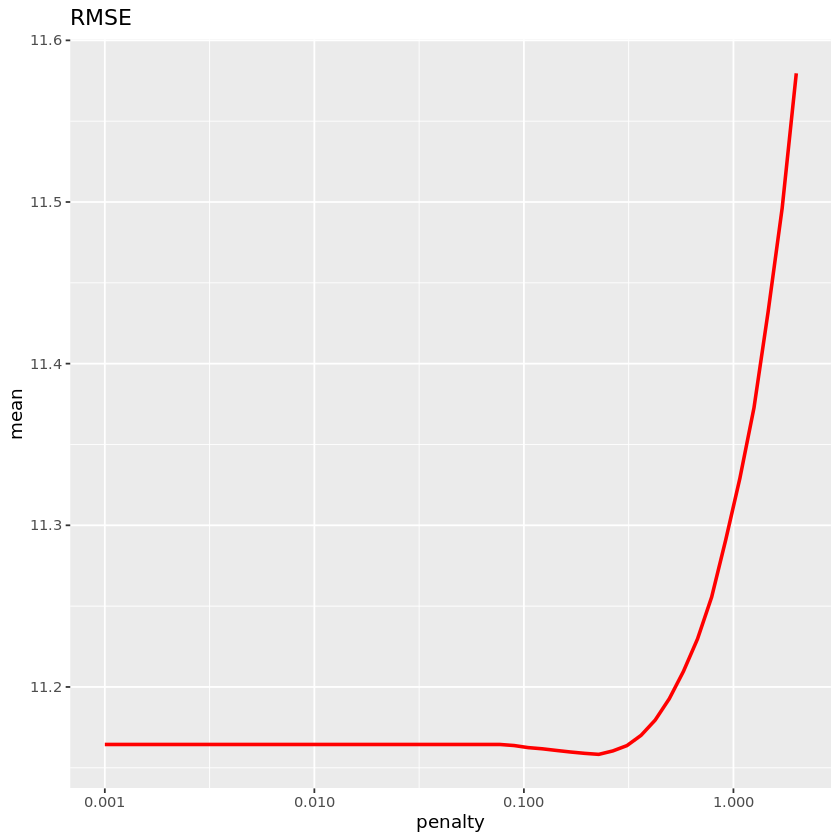

In [35]:
lasso_grid %>%
  collect_metrics() %>%
  filter(.metric == "rmse") %>%
  ggplot(aes(penalty, mean)) +
  geom_line(size=1, color="red") +
  scale_x_log10() +
  ggtitle("RMSE")

The dip in the RMSE graph corresponds to the best value for lambda. So again, we see that using lambda (penalty) of about 1.46 gives the best result.


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #5): </h1>
Perform a grid search for the lambda (penalty) parameter on ridge regression, then find the best values of the parameter.
</div>


In [36]:
# Write your code below and press Shift+Enter to execute 
tune_spec <- linear_reg(
             penalty = tune(), 
             mixture = 0) %>% 
  set_engine("glmnet")

ridge_grid <- tune_grid(ridge_wf %>% 
    add_model(tune_spec), 
    resamples = flight_cvfolds, 
    grid = lambda_grid)

show_best(ridge_grid, metric = "rmse")

penalty,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>
0.001000000,rmse,standard,11.44427,10,0.6923435,Preprocessor1_Model01
0.001167742,rmse,standard,11.44427,10,0.6923435,Preprocessor1_Model02
0.001363622,rmse,standard,11.44427,10,0.6923435,Preprocessor1_Model03
0.001592358,rmse,standard,11.44427,10,0.6923435,Preprocessor1_Model04
0.001859464,rmse,standard,11.44427,10,0.6923435,Preprocessor1_Model05


<details>
    <summary>Click here for the solution.</summary>

```r
tune_spec <- linear_reg(
             penalty = tune(), 
             mixture = 0) %>% 
  set_engine("glmnet")

ridge_grid <- tune_grid(ridge_wf %>% 
    add_model(tune_spec), 
    resamples = flight_cvfolds, 
    grid = lambda_grid)

show_best(ridge_grid, metric = "rmse")
```

</details>


<h1>Thank you for completing this notebook!</h1>

Checkout the documentation here: [https://www.tidymodels.org/](https://www.tidymodels.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDA0151ENSkillsNetwork21582452-2021-01-01).


<h3>About the Authors:</h3>

This notebook was written by <a href="https://www.linkedin.com/in/yiwen-li-47a019119/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDA0151ENSkillsNetwork21582452-2021-01-01" target="_blank">Yiwen Li</a> and <a href="https://www.linkedin.com/in/gabrieladequeiroz/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDA0151ENSkillsNetwork21582452-2021-01-01" target="_blank">Gabriela de Queiroz</a>.

<p><a href="https://www.linkedin.com/in/yiwen-li-47a019119/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDA0151ENSkillsNetwork21582452-2021-01-01" target="_blank">Yiwen Li</a> has approximately three year experiences in big tech industry. Currently, she is a developer advocate, a data scientist, a product manager at IBM, where she designs and develops data science solutions and Machine Learning models to solve real world problems. She has delivered talks this year in JupyterCon, PyCon, Pyjamas, CrowdCast.ai, Global AI on Tour 2020 and Belpy 2021 with hundreds of attendants per talk. 

<a href="https://www.linkedin.com/in/gabrieladequeiroz/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDA0151ENSkillsNetwork21582452-2021-01-01" target="_blank">Gabriela de Queiroz</a> is a Sr. Engineering & Data Science Manager at IBM where she manages and leads a team of developers working on Data & AI Open Source projects. She works to democratize AI by building tools and launching new open source projects.
She is the founder of AI Inclusive, a global organization that is helping increase the representation and participation of gender minorities in Artificial Intelligence. She is also the founder of R-Ladies, a worldwide organization for promoting diversity in the R community with more than 190 chapters in 50+ countries.
She has worked in several startups and where she built teams, developed statistical models, and employed a variety of techniques to derive insights and drive data-centric decisions


<hr>
<p>Copyright &copy; 2021 IBM Corporation. All rights reserved.</p>
